In [40]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [41]:
from fastai.vision import *
from fastai.datasets import *

In [42]:
PATH = Path('/home/jupyter/.fastai/data/pascal')

In [43]:
trn_j = json.load((PATH/'pascal_train2007.json').open())

In [44]:
IMAGES, TYPE, ANNOTATIONS, CATEGORIES = ['images', 'type', 'annotations', 'categories']

In [45]:
FILE_NAME, ID, IMG_ID, CAT_ID, BBOX = 'file_name', 'id', 'image_id', 'category_id', 'bbox'

In [46]:
cats = {o[ID]: o['name'] for o in trn_j[CATEGORIES]}

In [47]:
trn_fns = {o[ID]: o[FILE_NAME] for o in trn_j[IMAGES]}

In [48]:
trn_ids = [o[ID] for o in trn_j[IMAGES]]

In [49]:
JPEGS = 'VOCdevkit/VOC2007/JPEGImages'

In [50]:
def hw_bb(bb):
    return np.array([bb[1], bb[0], bb[1]+bb[3], bb[0]+bb[2]])

In [51]:
trn_anno = collections.defaultdict(lambda: [])

In [52]:
for o in trn_j[ANNOTATIONS]:
    if not o['ignore']:
        bb = o[BBOX]
        bb = hw_bb(bb)
        trn_anno[o[IMG_ID]].append((bb, o[CAT_ID]))

In [53]:
def get_lrg(b):
    if not b: raise Exception()
    b = sorted(b, key = lambda x: np.product(x[0][-2:] - x[0][:2]), reverse = True)
    return b[0]

In [54]:
trn_lrg_anno = collections.defaultdict(lambda: [])

In [55]:
trn_lrg_anno = {a: get_lrg(b) for a, b in trn_anno.items()}

In [56]:
bb = np.array([trn_lrg_anno[o][0] for o in trn_ids])

In [57]:
bb = [' '.join(str(p) for p in o) for o in bb]

In [58]:
df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'bbox': bb}, columns = ['fn', 'bbox'])

In [59]:
bb_anno = {o: trn_lrg_anno[o][0] for o in trn_ids}

In [60]:
trn_fns_id = {o[FILE_NAME]: o[ID] for o in trn_j[IMAGES]}

In [61]:
def name(filename):
    return str(filename)[-10:]

def get_bb(f):
    bb = list(bb_anno[trn_fns_id[name(f)]])
    lbl = cats[trn_lrg_anno[trn_fns_id[name(f)]][1]]
    return [[bb], [lbl]]

def get_bbpoints(f):
    getbb = get_bb(f)
    y1,x1,y2,x2 = getbb[0][0]
    y1, y2 = float(y1), float(y2)
    return tensor([y1,x1], [y1, x2], [y2,x1], [y2,x2])

In [63]:
data = (PointsItemList.from_csv(PATH, 'tmp/bb.csv', folder = JPEGS)
       .split_by_rand_pct(0.2)
       .label_from_func(get_bbpoints)
       .transform(resize_method = ResizeMethod.SQUISH, tfm_y = True, size = 300)
       .databunch(bs = 16).normalize(imagenet_stats))

In [66]:
learner = cnn_learner(data, models.resnet34)

In [67]:
learner.loss_func = MSELossFlat()

In [68]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


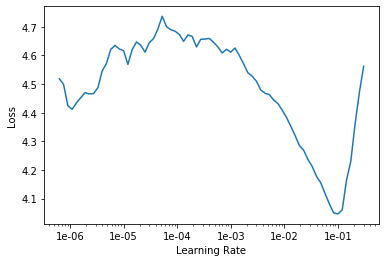

In [69]:
learner.recorder.plot()

Learner(data=ImageDataBunch;

Train: LabelList (2001 items)
x: PointsItemList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: PointsLabelList
ImagePoints (300, 300),ImagePoints (300, 300),ImagePoints (300, 300),ImagePoints (300, 300),ImagePoints (300, 300)
Path: /home/jupyter/.fastai/data/pascal;

Valid: LabelList (500 items)
x: PointsItemList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: PointsLabelList
ImagePoints (300, 300),ImagePoints (300, 300),ImagePoints (300, 300),ImagePoints (300, 300),ImagePoints (300, 300)
Path: /home/jupyter/.fastai/data/pascal;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil